# HW 4 - Supervised Learning at Scale.
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the first three homeworks you became familiar with the Map-Reduce programming paradigm as manifested in the Hadoop Streaming and Spark frameworks. We explored how different data structures and design patterns can help us manage the computational complexity of an algorithm. As part of this process you implemented both a supervised learning alogorithm (Naive Bayes) and an unsupervised learning algorithm (synonym detection via cosine similarity). In both of these tasks parallelization helped us manage calculations involving a large number of features. However a large feature space isn't the only situation that might prompt us to want to parallelize a machine learning algorithm. In the final two assignments we'll look at cases where the iterative nature of an algorithm is the main driver of its computational complexity (and the reason we might want to parallelize it).

In this week's assignment we'll perform 3 kinds of linear regression: OLS, Ridge and Lasso. As in previous assignments you will implement the core calculations using Spark RDDs... though we've provided more of a code base than before since the focus of the latter half of the course is more on general machine learning concepts. By the end of this homework you should be able to:  
* ... __define__ the loss functions for OLS, Ridge and Lasso regression.
* ... __calculate__ the gradient for each of these loss functions.
* ... __identify__ which parts of the gradient descent algorithm can be parallelized.
* ... __implement__ parallelized gradient descent with cross-validation and regularization.
* ... __compare/contrast__ how L1 and L2 regularization impact model parameters & performance.

Additional Reference: [Spark 2.2 Documentation - RDD programming guide](https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html)

__Please refer to the `README` for homework submission instructions and additional resources.__ 

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw4_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Opimization Theory 

As you know from w207, Gradient Descent is an iterative process that seeks to find the optimal parameters for a model given a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss. In live session 6 you discussed some of the theory behnid why gradient descent works and looked at a small example of gradient descent in the context of linear regression.

### Q1 Tasks:

* __a) short response:__ What are the first and second order conditions for convexity and why do we care about them when performing Gradient Descent?

* __b) short response:__ Explain the relationship between problem domain space and model parameter space in the context of Gradient Descent. In practice, why can't we find the optimal model by simply looking at the error surface in model parameter space?

* __c) short response:__ In the context of Gradient Descent, what is the 'learning rate' and what are the tradeoffs associated with setting this hyperparameter?

* __d) BONUS:__ In the context of OLS, what do we mean by a 'closed form solution' and why is it not scalable?

### Q1 Student Answers:
> __a)__ The First Order Condition (or 'first derivative rule') for convexity is that the maximum or minimum of an unconstrained function must occur at a point where the first derivative is 0 (or in the case of higher dimensions, where all first partial derivatives equal 0).  The Second Order Condition is that a minimum occurs when the first derivative is zero and the second derivative (or second partial derivatives) is/are positive, and that a maximum occurs when when the first derivative is zero and the second derivative is negative.  Gradient Descent seeks to minimize a loss function, so these conditions are important for ensuring that parameter updates are being made in the correct direction (towards a local minimum).  Additionally, if the second derivatives never change sign, then the local minimum of the loss function is also the absolute minimum.

> __b)__ In the problem domain space, one can think of loss as a measure of how far off the data are from the model-- loss is a function of the training data.  In the model parameter space, one can think of loss as a measure of how far off the current model is from the optimal model-- loss is a function of the parameters.  In practice, finding the optimal model requires more than just looking at the error surface of the model parameters.  It could be the case that the complexity of the model needs to be changed to obtain a better-fitting decision boundary, which is the problem domain space.  Also, there are typically more than two parameters in a real machine learning model, in which case an error surface can't be visualized.  Creating an error surface also means calculating the loss for many combinations of parameters, which is computationally expensive and inefficient.

> __c)__ The learning rate is a multiplicative factor that controls the size of parameter updates in gradient descent.  If the learning rate is too small, gradient descent will be slower than necessary.  If the learning rate is too large, then the parameter updates can overshoot the minimum, and possibly fail to converge.

> __d)__ In the context of OLS, a 'closed form solution' means solving the equation $0 = \frac{2}{n}\sum_{i=1}^n [\theta\cdot x'_i - y_i]\cdot x'$ for $\theta$. This is not scalable because it becomes computationally challenging in higher dimensions (the sizes of $\theta$ and $x'$ grow) and as the data grows (n increases).  Additionally, for some models an analytic solution may not exist and a numerical approximation must be used.

# About the Data

For the main task in this portion of the homework you will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.  Use the following cells to download the data, add a field for red/white, and split it into a test and train set.

In [5]:
# make a data folder & download red & white wine files
!mkdir data
#!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
#!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

mkdir: cannot create directory `data': File exists


In [5]:
!head data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		
0		893			4392		0	0	0		0			68fd1e64	2c16a946	a9a87e68	2e17d6f6	25c83c98	fe6b92e5	2e8a689b	0b153874	a73ee510	efea433b	e51ddf94	a30567ca	3516f6e6	07d13a8f	18231224	52b8680f	1e88c74f	74ef3502			6b3a5ca6		3a171ecb	9117a34a		
0	3	-1		0	2	0	3	0	0	1	1		0	8

In [16]:
header = !head -n 1 data/train.txt
header = header[0]
header

'0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16'

In [17]:
header.split('\t')

['0',
 '1',
 '1',
 '5',
 '0',
 '1382',
 '4',
 '15',
 '2',
 '181',
 '1',
 '2',
 '',
 '2',
 '68fd1e64',
 '80e26c9b',
 'fb936136',
 '7b4723c4',
 '25c83c98',
 '7e0ccccf',
 'de7995b8',
 '1f89b562',
 'a73ee510',
 'a8cd5504',
 'b2cb9c98',
 '37c9c164',
 '2824a5f6',
 '1adce6ef',
 '8ba8b39a',
 '891b62e7',
 'e5ba7672',
 'f54016b9',
 '21ddcdc9',
 'b1252a9d',
 '07b5194c',
 '',
 '3a171ecb',
 'c5c50484',
 'e8b83407',
 '9727dd16']

In [32]:
header2 = !head -n 2 data/train.txt
header2 = header2[1]
np.array(header2.split("\t")[:14], dtype = np.float)

ValueError: could not convert string to float: 

In [5]:
# extract header fields - RUN THIS CELL AS IS
#header = !head -n 1 data/reds.csv
#header = header[0]
#FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [36]:
original_trainRDD = sc.textFile('data/train.txt')
original_testRDD = sc.textFile('data/test.txt')

In [33]:
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t'))
    label,features = fields[0], fields[1:]
    return(features, label)

In [34]:
def parse_numbers(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t')[:14])
    label,features = fields[0], fields[1:]
    return(features, label)

In [35]:
def parse_categories(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t'))
    label,features = fields[0], fields[14:]
    return(features, label)

In [37]:
trainRDD, heldOutRDD = original_trainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


In [38]:
numeric_trainRDDCached = trainRDD.map(parse_numbers).cache()
categorical_trainRDDCached = trainRDD.map(parse_categories).cache()

In [40]:
numeric_sample = np.array(numeric_trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000))
numeric_sample_df = pd.DataFrame(np.array(numeric_sample))#, columns = FIELDS)

In [ ]:
numeric_sample_df.head()

In [ ]:
categorical_sample = np.array(categorical_trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000))
categorical_sample_df = pd.DataFrame(np.array(categorical_sample))#, columns = FIELDS)

In [6]:
# load the raw data into an RDD - RUN THIS CELL AS IS
#redsRDD = sc.textFile('data/reds.csv')\
#            .filter(lambda x: x != header)\
#            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
#whitesRDD = sc.textFile('data/whites.csv')\
#              .filter(lambda x: x != header)\
#              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine

In [7]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
#trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)
#print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.


In [8]:
# helper function - RUN THIS CELL AS IS
#def parse(line):
#    """
#    Map record_csv_string --> (tuple,of,fields)
#    """
#    fields = np.array(line.split(';'), dtype = 'float')
#    features,quality = fields[:-1], fields[-1]
#    return(features, quality)

In [9]:
# cache the training set - RUN THIS CELL AS IS 
#trainRDDCached = trainRDD.map(parse).cache()

# Question 2: EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

In this question we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

### Q2 Tasks:
* __a) short response:__ Run the provided code to sample 1000 points and visualize histograms of each feature. Comment on the distributions you observe (eg. _Which features appear normaly distributed, which don't? Which features vary most/least?_) How is the varaible `color` different than the other features & what does that mean about how we interpret its regression coefficient?

* __b) short response:__ Run the provided code to create boxplots of each feature. Which, if any, appear to have a positive linear relationship with `quality`? Which if any appear to have a negative linear relationship with `quality`?


* __c) short response:__ Run the provided code to plot the correlations matrix. Which pairs of features are most _strongly_ (postively or negatively) associated with each other? What implications would that have for our feature selection?

### Q2 Student Answers:
> __a)__ The sample histograms of the density and pH variables resemble a normal distribution (pH does show minor evidence of a small positive skew).  It is possible that total sulfur dioxide would have a normal distribution if it didn't have a lower bound of 0.  Otherwise, all other variables (except for color) have a strong positive skew.  The color and chlorides variables vary the least-- the peaks of their distributions are at 800 and 500 counts, respectively, which is a majority of the total sample size of 1000.  The alcohol and density variables vary the most-- their most populous values have only ~150 and 120 occurrences.

> The color variable is different from all others because instead of being continuous, it is a discrete variable (specifically, a binary indicator).  Whereas the regression coefficient for the other variables would be interpreted as the change in quality when increasing that variable's value by 1, the interpretation of the regression coefficient for the color variable is interpreted as the effect on or difference in quality when color is present versus when it is not.

> __b)__ The free sulfur dioxide, alcohol, and sulphates variables show evidence of a positive correlation with the quality variable (only to a minor degree for sulphates).  The fixed acidity, volatile acidity, chlorides, and density variables show evidence of a negative correlation with the quality variable.  It is unclear from the boxplots how citric acid, residual sugar, pH, and total sulfur dioxide relate to quality.

> __c)__ As one might expect, the total sulfur dioxide and free sulfur dioxide variables are highly positively correlated with one another, and including both variables in a regression would introduce a high amount of collinearity.  The consequence of collinearity is that the estimates for the affected variables may not be valid.  There is also a strong positive correlation between the color and volatile acidity variables.  Total sulfur dioxide also has a strong negative correlation with color, and the density / alcohol pair has a similiarly strong negative correlation.  For statistical analysis, predictors with collinearity will have invalid effect estimates, and such confounded coefficient estimates could lead to prediction error on new, unseen data.  Since the correlation for some pairs of variables is strong, it would be best to include only one variable from each pair of strongly correlated variables during feature selection-- this would reduce multicollinearity and the effect of the omitted variable would still likely be captured by the variable(s) with which it is correlated.

In [10]:
# part a - take a 1000 point sample for EDA (RUN THIS CELL AS IS)
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

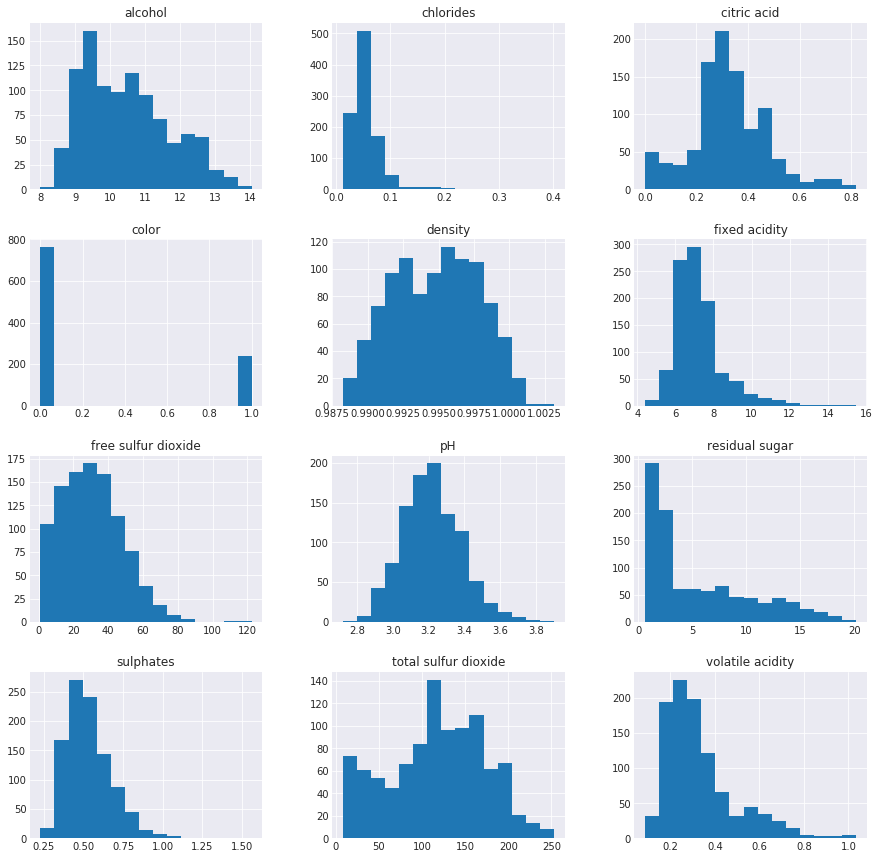

In [11]:
# part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

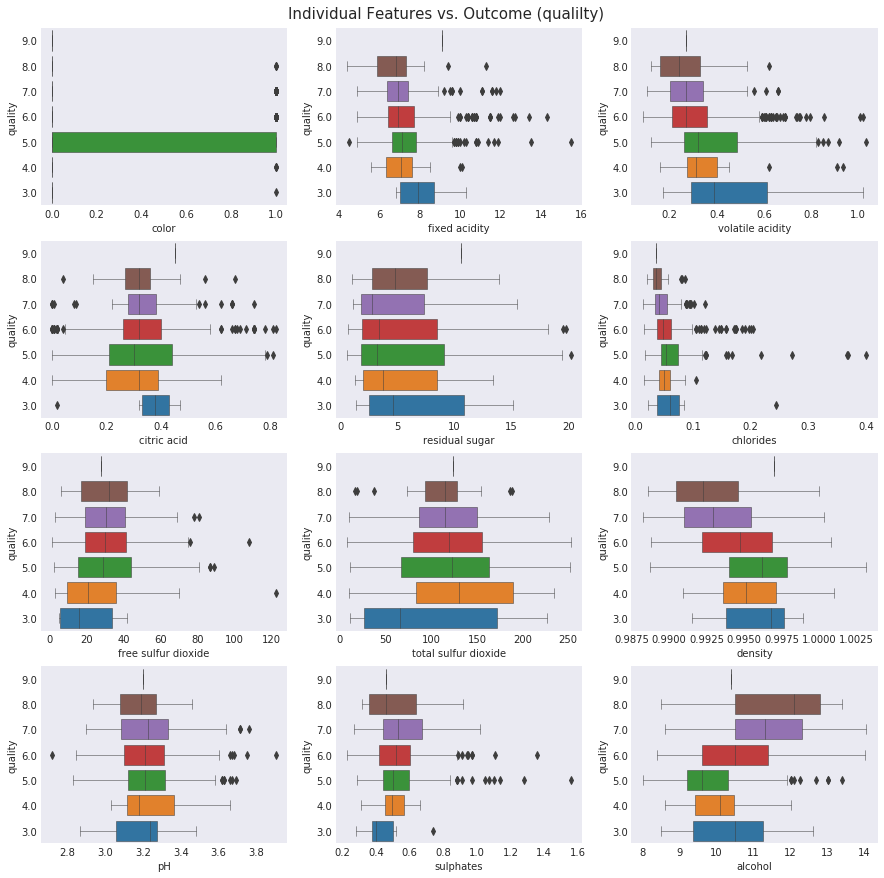

In [12]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df['quality']
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

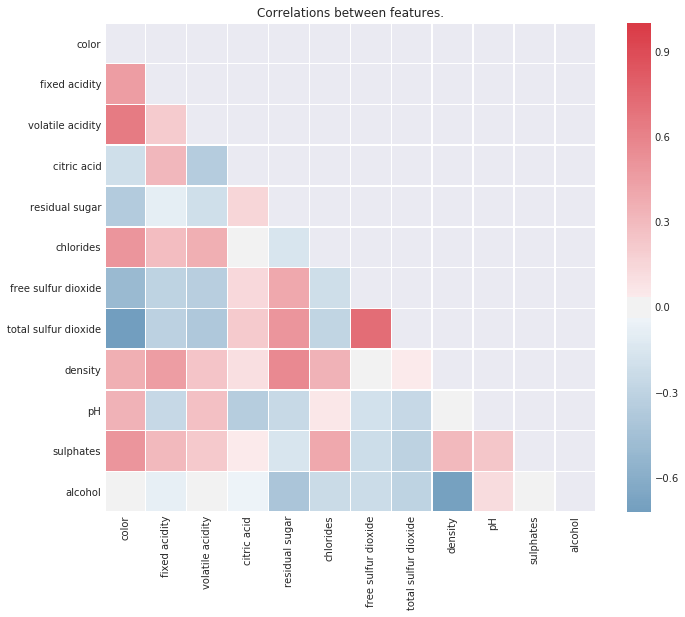

In [13]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

# Question 3: OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. In this question you'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. You'll reuse this function in Q4 when you implement gradient descent.

### Q3 Tasks:
* __a) code:__ Fill in the code below to compute the mean and variance of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]


* __b) short response:__ Write the formula for the OLS loss function and explain how to interpret it graphically.


* __c) short response:__ In the context of linear models & vector computations what does it mean to 'augment' a data point and why do we do this?


* __d) code + short response:__ Fill in the missing code to complete the`OLSLoss` function. Is computing the loss "embarassingly parallel'? Explain. [__`TIP:`__ Use `augmentedData` as your input when computing the loss.]

* __e) code + short response:__ Fill in the missing code to define a baseline model for this data set that has a bias term equal to the mean of your outcome variable and `0.0` for all coefficients. Note that in the docstring for `OLSLoss` we specified that the model should be a numpy array with the bias in the first position. Once you've defined your model, run the provided cells to check that your model has the correct dimensions and then compute the loss for your baseline model. Compare your results to the result you got in `part a` and explain what you see.

### Q3 Student Answers:
> __b)__ The OLS loss function is: $\frac{1}{n} \sum_{j=1}^n [(w^T x_j + b) - y_i]^2 $. where $n=|X_{train}|$.  The curve or surface created by the OLS loss function is convex, which means that its second derivative never changes sign and that gradient descent is guaranteed to find the global minimum.  The parameters that correspond to this minimum are the best estimates.

> __c)__ In the above loss function, the regression intercept is added after the dot product of the parameter and predictor matrices.  Augmenting a data point means appending a value of 1 to the predictor array and appending a parameter for this constant to the parameter array-- this allows the prediction to be calculated in one vectorized computation step (the dot product), instead of two (dot product and element-wise addition of the intercept).  Augmenting a) streamlines the prediction calculation, and b) simplifies the code.

> __d)__ Computing the loss, specifically the quantity $[(w^T x_j + b) - y_i]^2$, should be considered embarrassingly parallel.  For each observation or row of the data, this calculation is completely independent of all other observations.  It is associative because it does not matter which partitions perform this calculation for which observations, and it is commutative because the order in which this happens does not matter.

> __e)__ The loss calculated for the baseline model is the same as the variance of the response (quality).  When the intercept ($b$ in the formula from part b) is set to the average response value and all other parameters ($W$ in the formula from part b) are zero, the quantity $w^T x_j + b$ will always be the average response value, since $w^T x_j=0$ and $b=meanQuality$.  In this case, the loss calculation becomes $\frac{1}{n} \sum_{j=1}^n [meanQuality - y_i]^2 $, which is the same as the calculation for variance.

In [10]:
# part a - mean and variance of the outcome variable 
meanQuality = trainRDDCached.map(lambda observation: observation[1]).reduce(lambda x,y: x+y) / trainRDDCached.count() # FILL IN YOUR CODE HERE
varQuality = trainRDDCached.map(lambda observation: (observation[1]-meanQuality)**2).reduce(lambda x,y: x+y) / (trainRDDCached.count() - 1) # FILL IN YOUR CODE HERE
print(f"Mean: {meanQuality}")
print(f"Variance: {varQuality}")

Mean: 5.81104033970276
Variance: 0.7602332997237472


In [11]:
# part d - write function to compute loss (FILL IN MISSING CODE BELOW)
def OLSLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    lossRDD = augmentedData.map(lambda observation: (np.dot(W,observation[0])-observation[1])**2).cache()
    n = lossRDD.count()
    loss = lossRDD.reduce(lambda x,y: x + y)/n
    ################## (END) YOUR CODE ##################
    return loss

In [12]:
# part e - define your baseline model here
BASELINE = np.array([meanQuality, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
# part e - compute the loss for your baseline model (RUN THIS CELL AS IS)
assert len(BASELINE) == len(trainRDDCached.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {OLSLoss(trainRDDCached, BASELINE)}")

Baseline model loss: 0.7600865648656651


# Question 4: Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. In this question you'll implement gradient descent for OLS regression and take a look at a few update steps.

### Q4 Tasks:
* __a) short response:__ Jimi describes the main part of the gradient calculation for OLS Regression using a short mantra: _'the sum of the data weighted by the errors'_. . Write the formula for the gradient and explain how it reflects this phrase. 

* __b) short response:__ Looking at the formula you wrote in `part a`, what parts of this calculation can be parallelized and what has to happen after reducing?


* __c) code:__ Fill in the missing lines in `GDUpdate` to compute the gradient and perform a single update of the model parameters.   
    * __`TIP 1:`__ _remember that the gradient is a vector of partial derivatives, `grad` should be a numpy array_    
    * __`TIP 2:`__ _Spark's built in `mean()` function may help you here_  


* __d) short response:__ Run the provided code to perform 5 steps of Gradient Descent on our data. What is wrong with these results?


* __e) code + short response:__ Fill in the missing code in `normalize` so that this function scales each feature and centers it at 0. Then use the provide code block to rerun your same gradient descent code on the scaled data. Use these results to explain what the problem was in 'd'.
    * __`TIP:`__ _You may find [this brief illustration](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da) from Andrew Ng's Coursera helpful._


### Q4 Student Answers:
> __a)__ The formula for the gradient is: $\nabla_{\theta} f(\theta) = \frac{2}{n}\sum_{i=1}^n[\theta \cdot x'_i - y_i]\cdot x'_i$.  The quantity $[\theta \cdot x'_i - y_i]$ is the predicted response minus the actual response, which is the error.  Every variable for that data point is muliplied by this error, so the data is thus weighted by the error.  These datapoints weighted by the errors of their prediction are then summed.

> __b)__ In the above formula, the quantity $[\theta \cdot x'_i - y_i]\cdot x'_i$ can be parallelized.  After reducing with a sum, the result still needs to be multiplied by $\frac{2}{n}$.

> $n$ can also be obtained before computing $[\theta \cdot x'_i - y_i]\cdot x'_i$, in which case the factor $\frac{2}{n}$ can instead be included in the parallelized computation, however, this order of operations would not provide any improvements in terms of speed or computational complexity.

> __c)__ _complete the coding portions of this question before answering d & e_ 

> __d)__ With each iteration, the loss actually increases, the magnitudes of the parameter estimates become increasingly larger, and the direction of the estimates (their sign) also alternates-- gradient descent fails to converge and in fact, diverges.

> __e)__ The EDA shows that the predictors are on vastly different scales.  For example, in the sample examined above, total sulfur dioxide ranges from 0 to 250, while chlorides ranges from 0 to 0.4.  Given matching or similar initialization of the parameters, the absolute error due to total sulfur dioxide is likely to be very different from that due to chlorides, and the gradient is thus calculated off of a prediction error that is not appropriate for one or both variables.  This would make the gradient step for one of the parameters either way too large or way too small-- for the code in part c, the bad gradient calculation leads to a large error, which then gets over-corrected into an even larger error in the opposite direction in the next iteration, and this cycle repeats itself into divergence.  Normalizing the variables allows the calculated gradient to be on an appropriate scale for all variables, so that unrepresentative gradient steps and large over-corrections do not occur.

In [14]:
# part b - function to perform a single GD step
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE ################# 
    #n = augmentedData.count()
    #gradRDD = augmentedData.map(lambda observation: (2.0/n)*(np.dot(W,observation[0])-observation[1])*observation[0]).cache()
    gradRDD = augmentedData.map(lambda observation: 2.0*(np.dot(W,observation[0])-observation[1])*observation[0])
    
    
    #grad = gradRDD.reduce(lambda x,y: np.add(x,y))
    grad = gradRDD.mean()
    new_model = W - (learningRate*grad)
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [15]:
# part c - take a look at a few Gradient Descent steps (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(trainRDDCached, model)
    loss = OLSLoss(trainRDDCached, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656651
----------
STEP: 1
Loss: 3255.0397706654694
Model: [5.811, -0.009, -0.017, -0.007, 0.002, -0.035, -0.001, 0.167, -0.489, -0.0, 0.0, 0.001, 0.094]
----------
STEP: 2
Loss: 41538896320.90905
Model: [15.998, 0.946, 71.311, 3.109, 3.394, 67.104, 0.517, 372.213, 1469.681, 10.133, 32.587, 5.197, 105.407]
----------
STEP: 3
Loss: 5.321516254248054e+17
Model: [-36732.224, -3790.819, -257459.013, -11294.195, -12193.785, -240557.886, -1880.28, -1359608.579, -5252902.327, -36544.479, -117571.505, -18781.008, -379946.295]
----------
STEP: 4
Loss: 6.81735537409684e+24
Model: [131498780.95, 13574790.866, 921540888.277, 40426173.604, 43645471.549, 861027822.897, 6730358.366, 4867148463.848, 18801163135.816, 130805962.538, 420832007.137, 67225003.981, 1359973545.811]
----------
STEP: 5
Loss: 8.733663880161468e+31
Model: [-470665198626.641, -48587550191.154, -3298412689020.274, -144694834630.276, -156217444459.915, -3081821742976.904, -24089547803.281, -174206930645

In [16]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: (np.subtract(x[0],featureMeans)/featureStdev, x[1]))
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [17]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(trainRDDCached).cache()

In [18]:
# part e - take a look at a few GD steps w/ normalized data  (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = OLSLoss(normedRDD, model) 
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656651
----------
STEP: 1
Loss: 0.6555276691703886
Model: [5.811, -0.02, -0.014, -0.045, 0.014, -0.007, -0.035, 0.009, -0.009, -0.054, 0.003, 0.008, 0.078]
----------
STEP: 2
Loss: 0.6150592390442611
Model: [5.811, -0.022, -0.014, -0.071, 0.023, -0.006, -0.05, 0.014, -0.021, -0.079, 0.007, 0.024, 0.131]
----------
STEP: 3
Loss: 0.5935522582531461
Model: [5.811, -0.018, -0.01, -0.09, 0.03, 0.002, -0.057, 0.02, -0.032, -0.09, 0.011, 0.04, 0.167]
----------
STEP: 4
Loss: 0.5798853360580276
Model: [5.811, -0.014, -0.006, -0.105, 0.034, 0.012, -0.061, 0.026, -0.04, -0.094, 0.013, 0.054, 0.195]
----------
STEP: 5
Loss: 0.5703196233260648
Model: [5.811, -0.009, -0.003, -0.117, 0.036, 0.024, -0.063, 0.032, -0.047, -0.096, 0.016, 0.066, 0.217]


# Question 5: Assessing the performance of your model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. In this question you'll plot error curves for a test and training set in order to discuss model performance. Note that although we split out a test & train set when we first loaded the data... in the spirit of keeping that 20% truly 'held out' until then end of the assignment, we'll make an additional split for the purposes of this question dividing the existing training set into two smaller RDDs.

### Q5 Tasks:
* __a) short response:__ Why doesn't the loss that we printed in Question 4 accurately reflect "how good" our model is? 


* __b) code:__ Since we're going to be running Gradient Descent a number of times let's package it into a function for convenience. Fill in the missing code in `GradientDescent()`, note that the missing code is going to look a lot like the provided code blocks in Q5 -- feel free to use those as a starting point.


* __c) short response:__ Use the provided code to split the normalized data into a test and train set, then run 50 iterations of gradient descent and plot the MSE curves for each. Describe what you see and speculate about why this might be happening.


* __d) short response:__ Note that passing the optional parameter `seed` to the Spark method `randomSplit` allows us to pseudo randomize our test/train split in a way that is replicable. Re-run the code for part 'c but this time in the line where we perform the `normedRDD.randomSplit` change the seed to _`seed = 5`_. What changes in the plot? Repeat for _`seed = 4`_. How does this change your interpret the results you saw in 'c'. What is the more likely explanation?

### Q5 Student Answers:
> __a)__ The loss printed in question 4 is the loss on the training data, which does not tell how the model would perform on new, unseen data.

> __c)__ The curves are very similar and decrease rapidly before leveling off at ~0.53 for training MSE and ~0.55 for test MSE.  The test MSE is always slightly higher than training MSE, and after about 20 iterations, gradient descent converges and the loss stops decreasing for both.  The test MSE being always slightly higher is most likely due to the fact that the test data has some observations whose predictor values are extreme and thus unaccounted for in the training data.

> __d)__ When the seed is changed to 5, the test MSE is lower than the training MSE in the early iterations, but as both curves level off and the algorithm converges, training MSE returns to being slightly lower than test MSE.  When the seed is changed to 4, the curves are again similar to how they were with the seed set to 2018-- the test and training MSE curves are very similar, with the test MSE always slightly higher than the training MSE.  This result is actually consistent with the interpretation from part c-- the degree to which the test and training MSE curves match or differ is dependent on the particular observations that are in the training data versus the test data.

In [19]:
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        if idx==0:
            augmentedTrainData = trainRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
            augmentedTestData = testRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
        #featureMeans = dataRDD.map(lambda x: x[0]).mean()
        #featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
        #normedRDD = dataRDD.map(lambda x: (np.subtract(x[0],featureMeans)/featureStdev, x[1]))
        grad = augmentedTrainData.map(lambda observation: 2.0*(np.dot(model,observation[0])-observation[1])*observation[0]).mean()
        model = model - (learningRate*grad)
        
        training_loss = augmentedTrainData.map(lambda observation: (np.dot(model,observation[0])-observation[1])**2).mean()
        test_loss = augmentedTestData.map(lambda observation: (np.dot(model,observation[0])-observation[1])**2).mean()
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [20]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [26]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
#trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
#trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 4)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 6.9972569942474365 seconds


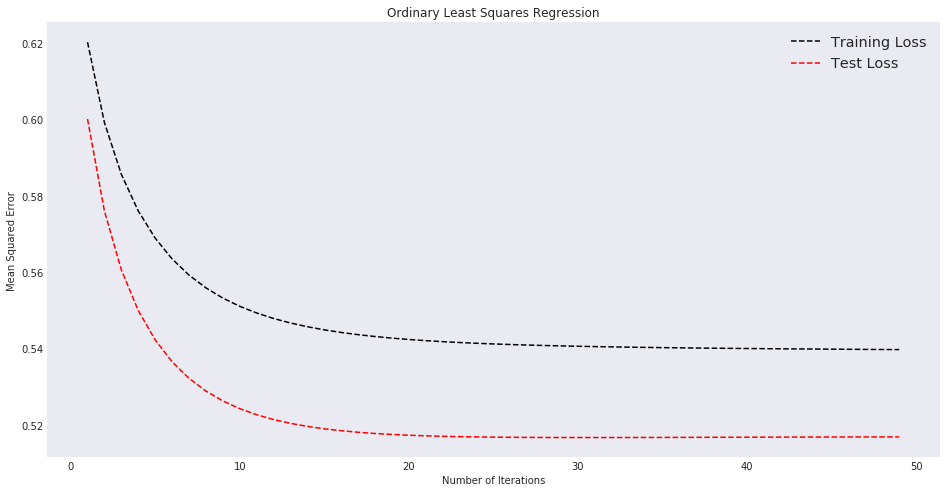

In [27]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [23]:
# save the models & their performance for comparison later (RUN THIS CELL AS IS)
np.savetxt(PWD + '/data/OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

# Question 6: Cross Validation

In question 5 we mentioned that computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place no shuffle needed for the aggregation. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw in question 5, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model. In this question we've provided a code base to perform gradient descent and cross validation in parallel. You'll fill in some of the key details based on your understanding from questions 1-5.

### Q6 Tasks:
* __a) short response:__ A naive approach to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 models in sequence. In this naive approach, how many total passes would be made over the data? [__`HINT:`__ _it will depend on factors that you should be able to name._]


* __b) short response:__ Read through the provided helper function `kResiduals()` and note where it gets used in the subsequent function `CVLoss()`. For each record in the original dataset, how many tuples does `kResiduals()` emit? What are the keys of these newly emitted records? How will these keys help us compute cross validated loss?


* __c) code:__ Complete the missing Spark code in `CVLoss()` so that this function returns the test/train cross validated error for a give set of data splits and their corresponding models. [__`TIP:`__ _your goal is to start from `partialLossRDD` and compute the test & train loss for each model so that the provided code can take the final average_].


* __d) code:__ Read through the provided functions `partialGradients()` and `CVUpdate()`. These should have a familiar feel. Fill in the missing line in `CVUpdate()` to update each model and add the (new) array of coefficients to the `new_models` list. 


* __e) short response:__ Read `GradientDescent_withCV()` and then run the provided code to perform 50 iterations and plot the error curves. What can you conclude from this graph? 

### Q6 Student Answers:
> __a)__ In the naive approach, $(2\cdot nSteps + 1)\cdot k$ passes must be made over the data-- each of the k models must perform $nSteps$ iterations over the data, and in each iteration, two passes are made over the data-- one to calculate the gradient, and the other to calculate loss.  Also, for each model, an additional first pass must be made over the data to produce the augmented data.

> __b)__ For each record in the original dataset, kResiduals() emits k tuples.  The keys of these newly emitted records is a string representing the model number and whether the loss calculated is for training data or test data.  This helps with a subsequent aggregation or reduction by key-- for each model, the training and test losses will be aggregated/reduced separately due to this key.  This in turn allows the correct aggregating of all test losses and all training losses.

> __e)__ Whereas in Question 5, the test loss sometimes was lower than the training loss, when using cross-validation, the test loss is always slightly higher than the training loss, which makes sense-- this plot illustrates that loss on unseen data will always be higher than the loss on training data.

In [28]:
# part b - helper function to emit residuals (RUN THIS CELL AS IS)
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the (squared) residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the trainin set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", (W.dot(X) - y)**2)
        else:
            yield(f"{modelNum}-train", (W.dot(X) - y)**2)

In [29]:
# part c - fill in the missing code below
def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    
    ################ YOUR CODE HERE #################        
    loss = partialLossRDD.aggregateByKey((0,0), lambda x,y: (x[0]+y,x[1]+1), lambda x,y: (x[0]+y[0],x[1]+y[1])) \
                         .mapValues(lambda z: z[0]/z[1]) \
                         .collect()
    
    
    
    
    ################ (END) YOUR CODE ################# 
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [30]:
# part d - helper function RUN THIS CELL AS IS
def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(W.dot(X) - y)*X, 1])

In [31]:
# part d - perform GD updates for all k models (FILL IN MISSING CODE BELOW)
def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        ############# YOUR CODE HERE ############
        new_models.append(W - (learningRate*grad))
        ############# (END) YOUR CODE ###########
    return new_models

In [32]:
# part e - RUN THIS CELL AS IS
def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist

In [33]:
# part d -  run 50 iterations (RUN THIS CELL AS IS)
dataSplits = normedRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = BASELINE
trainLoss, testLoss, models = GradientDescent_withCV(dataSplits, wInit, nSteps = 50, verbose=False)


... trained 50 iterations in 49.22368383407593 seconds


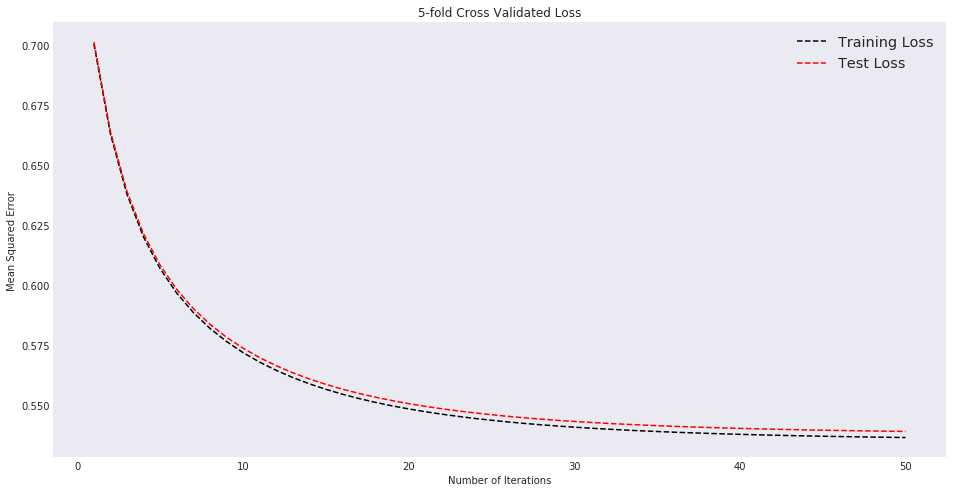

In [34]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(trainLoss, testLoss, title = '5-fold Cross Validated Loss' )

# Question 7: Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are $2^{p}$ potential models that can be built from $p$ features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. In this question you will implement Gradient Descent with ridge and lasso regularization.

__`IMPORTANT NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calcultion (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).

### Q7 Tasks:
* __a) short response:__ The regularization term for ridge regression is the square of the $L2$ norm of the weights vector (i.e. the sum of squares of the coefficients) times the regularization parameter, $\lambda$. Write the formulas for both the loss function and the gradient for Ridge Regularization and explain what extra step this will add to our gradient descent algorithm.


* __b) short response:__ The regularization term for lasso regression is the $L1$ norm of the weights vector (i.e. the sum of the absolute values of the coefficients) times the regularization parameter, $\lambda$. Write the formulas for both the loss function and the gradient for Lasso Regularization and explain how the gradient descent update in Lasso will be different than it was in Ridge.


* __c) code:__ Fill in the first two missing code blocks in `GDUpdate_wReg()` so that this function will perform a single parameter update using $L2$ regularization if the parameter `regType` is set to `ridge`, $L1$ regularization if set to `lasso` and unregularized OLS otherwise.


* __d) code + short response:__ Use the provided code to train 50 iterations of ridge and lasso regression and plot the test/train error. Comment on the curves you see. Does this match your expecatation?

### Q7 Student Answers:
> __a)__ The ridge regularization loss function is: $f(w,b) = \frac{1}{n}\sum_{i=1}^n[(w\cdot x_i + b) - y_i]^2 + \lambda \sum_{j=1}^m w^2_j$, and the ridge regularization gradient is: $\nabla_{\theta} f(\theta) = \frac{2}{n}\sum_{i=1}^n[(w \cdot x_i + b) - y_i]\cdot x_i + (2\lambda\cdot w)$.  Using ridge regularization adds an extra step between calculating the gradient and updating the model.  This extra step is to calculate $2\lambda\cdot w$, which is a vector of weights (each parameter rescaled by $2\lambda$), and then add this vector element-wise to the vector of partial gradients.

> __b)__ The lasso regularization loss function is: $f(w,b) = \frac{1}{n}\sum_{i=1}^n[(w\cdot x_i + b) - y_i]^2 + \lambda \sum_{j=1}^m |w_j|$, and the lasso regularization gradient is: $\nabla_{\theta} f(\theta) = \frac{2}{n}\sum_{i=1}^n[(w \cdot x_i + b) - y_i]\cdot x_i + (\lambda\cdot \frac{w}{|w|})$.  The gradient descent update in Lasso will be different in that the size of each parameter does not factor into its regularization.  The unweighted regularization term is either added to or subtracted from each partial gradient, based on the sign of the parameter value (the loss gradient taken with respect to the weights reduces $w$ to $\frac{\delta w}{\delta w}$).  If the weight is zero, then nothing is added or subtracted.

> __d)__ Although the training error is lower than the test error for both regressions after gradient descent converges, I did not expect the lasso test error to be lower than its training error in the early iterations.  It is also unexpected to see that in some later iterations of GD for lasso, the test error approaches or dips below the training error-- this is most likely due to the fact that lasso tends to shrink coefficient estimates to zero, and the reduced number of features in the model is better for generalizing to unseen data.

In [35]:
# part c - gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################
    grad = augmentedData.map(lambda observation: 2.0*(np.dot(W,observation[0])-observation[1])*observation[0]).mean()
    if regType == 'ridge':
        #2 * self.l2_reg * self._theta[1:]
        grad[1:] += 2*regParam*W[1:]
    elif regType == 'lasso':
        #self.l1_reg * np.sign(self._theta[1:])
        grad[1:] += regParam*np.sign(W[1:])
    new_model = W - (learningRate*grad)
    
    
    
    
    ################## (END) YOUR CODE ####################
    return new_model

In [36]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(OLSLoss(trainRDD, model))
        test_history.append(OLSLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [37]:
# run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.5 )
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 23.85761857032776 seconds


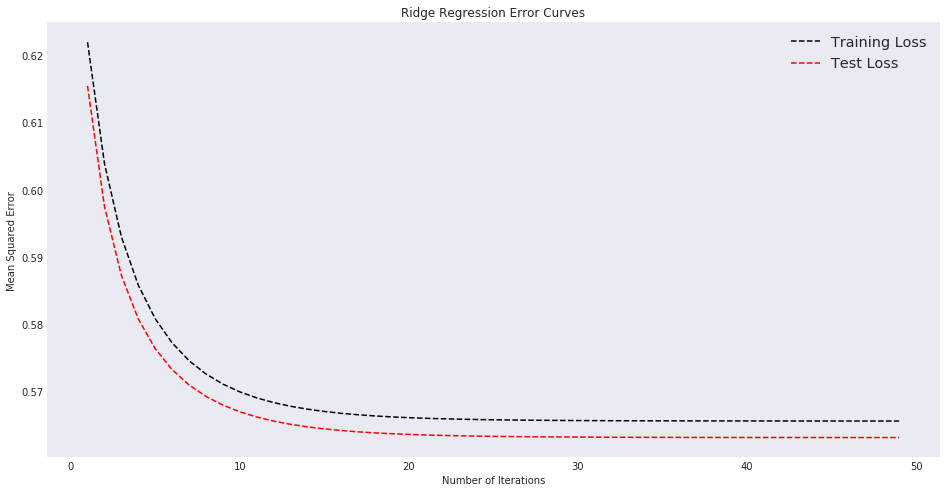

In [38]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = ridge_results
np.savetxt(PWD + '/data/ridge_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/ridge_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

In [39]:
# run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 22.739331483840942 seconds


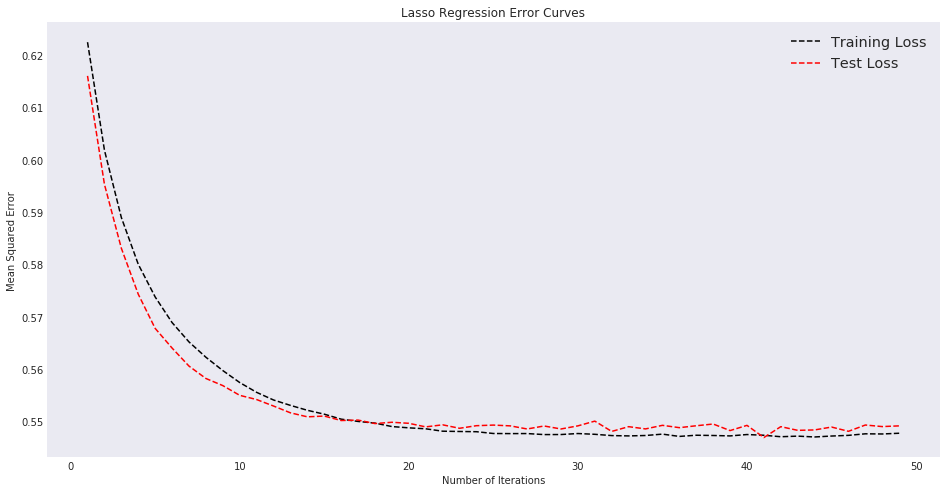

In [40]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = lasso_results
np.savetxt(PWD + '/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

# Question 8: Results

In this final question we'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method.

### Q8 Tasks:
* __a) code:__ Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method. Then compute the mean squared error on the held out dataset for each of the three models. [__`TIP:`__ _the held out data is in it's raw form, don't forget to parse and normalize before applying your calculations, you should also be careful to normalize using the same scaling parameters that you used for the training data._]

* __b) short response:__ Which model performed best? Discuss how you interpret these results and what you would want to try next.


* __c) short response:__ Use the provided code to plot side by side boxplots of the residuals vs. the outcome (i.e. `quality`). What can you observe about our model performance? [__`TIP:`__ _note that the heldout data set is plenty small enough to fit in memory so no need to sample. Feel free to do your plotting in pandas or any other comfortable python package._]


* __d) short response:__ Run the provided code to visualize the model coefficients for the first 50 iterations of training. What do you observe about how the OLS, ridge and lasso coefficients change over the course of the training process. Please be sure to discuss all three in your response.

### Q8 Student Answers:
> __b)__ The unregularized ols model seems to perform the best-- its loss on the test data is the lowest amongst the three models, which suggests that it generalizes the best.  However, each of these models was trained on a split of the training data (only 80%)-- the next thing to try would be to train the ols, ridge, and lasso regression models on the entire training data set before testing on the test set.  Alternatively, cross-validation can be used on the entire dataset to estimate what each model's test error would be.

> __c)__ All three models similarly show that for each actual quality response, the error is correlated with that response's offset from the average quality response.  This is an indication that the model tends to make predictions close to the average quality response-- in terms of the bias-variance tradeoff, these models have high bias, and low variance.

> __d)__ The model coefficients for the OLS model have a wide range of values and some coefficients (i.e. citric acid) change sign over the course of gradient descent.  After convergence, the model coefficient values seem to have an almost even spread.

> The range of model coefficient values for the ridge regression is all-around much more narrow-- for example, the largest coefficient (for fixed acidity) was above 0.3 for OLS but is only 0.2 for ridge regression.  The other coefficients in ridge-regression again seem evenly spread but in a much tighter range than in the OLS model.  It is interesting to see that the citric acid coefficient, which changed sign during gradient descent for the OLS model, did not change sign in the ridge regression model, and on a related note, it appears that gradient descent converges much earlier in ridge regression than in the OLS model.

> The coefficients for the lasso regression model are very different from those of the other two models.  The coefficients which are largest in magnitude (fixed acidity, volatile acidity, color, residual sugar, free sulfur dioxide, and total sulfur dioxide) are as large or larger than they are in the OLS model, but the remaining coefficients are shrunk to zero, and this illustrates the utility of the lasso method for variable selection.  Gradient descent does not seem to converge as quickly for lasso regression as it does for ridge regression.

In [41]:
# part a - load the models from file (RUN THIS CELL AS IS)
ols_models = np.loadtxt(PWD + '/data/OLSmodels.csv', dtype=float, delimiter=',')
ridge_models = np.loadtxt(PWD + '/data/ridge_models.csv', dtype=float, delimiter=',')
lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [42]:
# part a - compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
############### YOUR CODE HERE #################
featureMeans = trainRDDCached.map(lambda x: x[0]).mean()
featureStdev = np.sqrt(trainRDDCached.map(lambda x: x[0]).variance())

validationRDD = heldOutRDD.map(parse).map(lambda x: (np.subtract(x[0],featureMeans)/featureStdev, x[1])).cache()

olsMSE = OLSLoss(validationRDD, best_ols)
ridgeMSE = OLSLoss(validationRDD, best_ridge)
lassoMSE = OLSLoss(validationRDD, best_lasso)

############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

OLS Mean Squared Error: 0.5529543649488738
Ridge Mean Squared Error: 0.5847003942598668
Lasso Mean Squared Error: 0.5624143772925649


In [43]:
# part c - helper function (RUN THIS CELL AS IS)
def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [44]:
# part c - compute residuals for all three models (RUN THIS CELL AS IS)
ols_resid = np.array(get_residuals(validationRDD, best_ols))
ridge_resid = np.array(get_residuals(validationRDD, best_ridge))
lasso_resid = np.array(get_residuals(validationRDD, best_lasso))

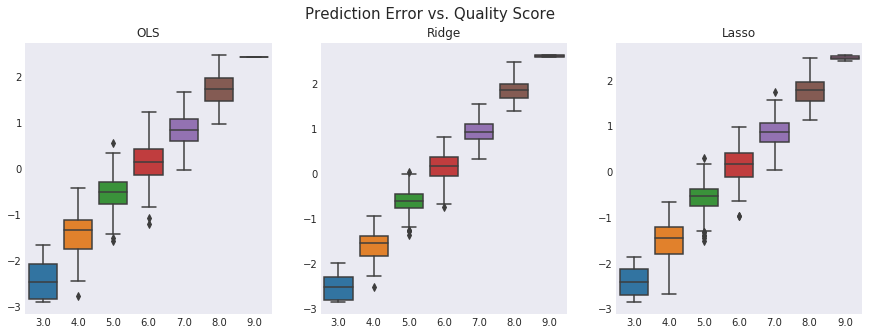

In [45]:
# part c - boxplots of residuals for all three models (RUN THIS CELL AS IS)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x, y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
plt.show()

In [46]:
# part d - plotting function (RUN THIS CELL AS IS)
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show

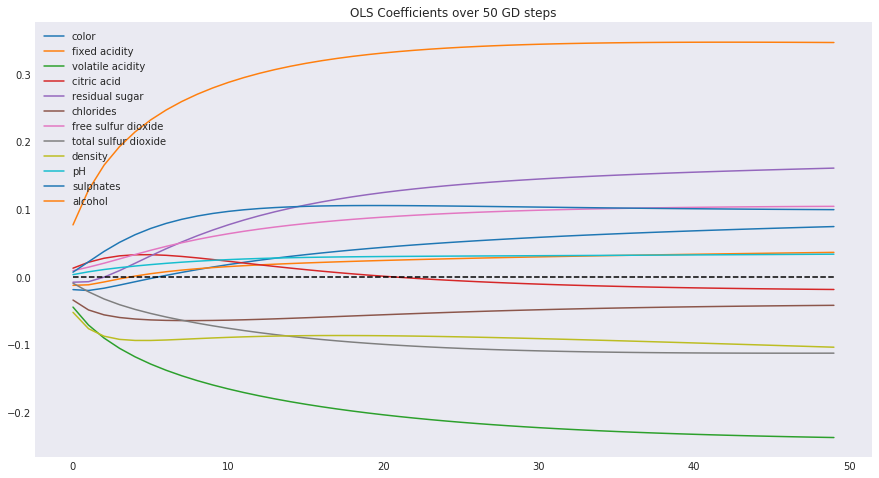

In [47]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

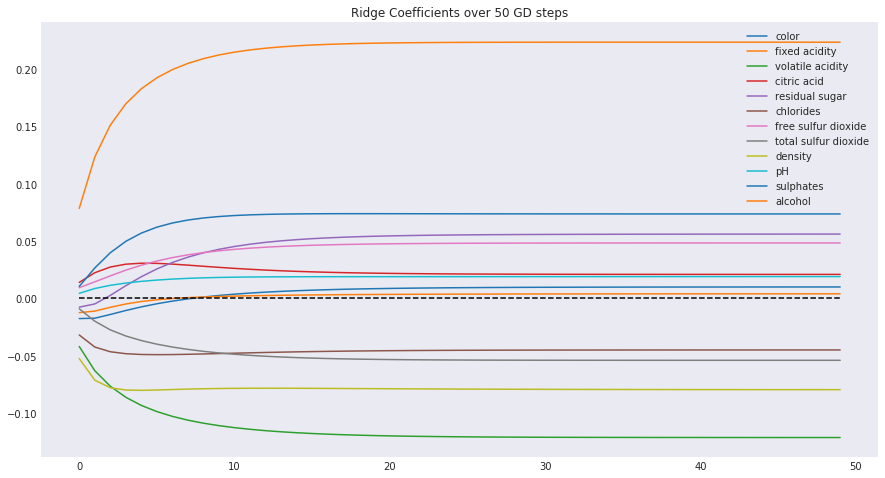

In [48]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

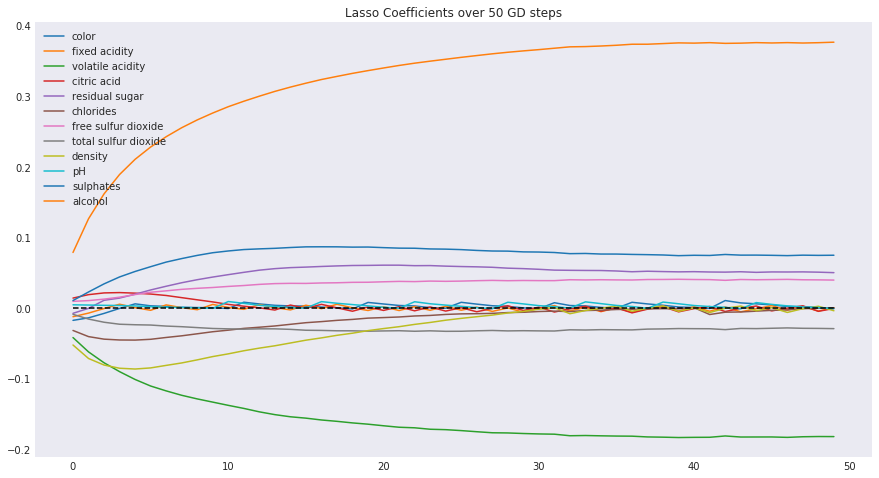

In [49]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

### Congratulations, you have completed HW4! Please refer to the readme for submission instructions.